In [26]:
#Load libraries and dataset

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import KFold
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from datetime import datetime

In [25]:
salaries = pd.read_csv("/Users/christian/Desktop/STAT486Final/data.csv")

In [3]:
salaries.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2022,EN,FT,Cyber Program Manager,63000,USD,63000,US,50,US,S
1,2022,MI,FT,Security Analyst,95000,USD,95000,US,0,US,M
2,2022,MI,FT,Security Analyst,70000,USD,70000,US,0,US,M
3,2022,MI,FT,IT Security Analyst,250000,BRL,48853,BR,50,BR,L
4,2022,EN,CT,Cyber Security Analyst,120000,USD,120000,BW,100,BW,S


In [4]:
print(salaries.columns)

Index(['work_year', 'experience_level', 'employment_type', 'job_title',
       'salary', 'salary_currency', 'salary_in_usd', 'employee_residence',
       'remote_ratio', 'company_location', 'company_size'],
      dtype='object')


### Exploring Unique Job Titles in the Dataset

This step helps in gaining insights into the diversity of cybersecurity roles and is crucial for any subsequent analysis that might focus on specific job titles or groups of titles.


In [5]:
titles = salaries['job_title'].unique()

for title in sorted(titles):
    print(title)

Application Security Analyst
Application Security Architect
Application Security Engineer
Application Security Specialist
Azure Security Engineer
Chief Information Security Officer
Cloud Security Architect
Cloud Security Engineer
Cloud Security Engineering Manager
Computer Forensic Software Engineer
Concierge Security Engineer
Corporate Infrastructure Security Engineer
Corporate Security Engineer
Cyber Program Manager
Cyber Security Analyst
Cyber Security Architect
Cyber Security Consultant
Cyber Security Engineer
Cyber Security Researcher
Cyber Security Specialist
Cyber Security Training Specialist
Cyber Threat Analyst
Cyber Threat Intelligence Analyst
Data Security Analyst
Detection Engineer
DevOps Security Engineer
DevSecOps Engineer
Digital Forensics Analyst
Director of Information Security
Enterprise Security Engineer
Ethical Hacker
Head of Information Security
Head of Security
IAM Engineer
IT Security Analyst
IT Security Engineer
IT Security Manager
Incident Response Analyst
Inci

### Feature Engineering and Standardization of Job Titles
This section of the notebook focuses on enhancing the dataset through feature engineering and standardizing job titles. Key steps and functionalities include:

1. **Standardizing Job Titles**: A function `standardize_title` is defined to map various job titles into broader categories like 'Engineer', 'Analyst', 'Manager', and 'Specialist'. This helps in simplifying the analysis by reducing the number of unique job titles.

2. **Identifying Management Roles**: The `is_manager` function checks if a job title belongs to a managerial role. This binary feature (1 for manager, 0 for non-manager) can be useful in analyses that differentiate between managerial and non-managerial roles.

3. **Creating Additional Features**: 
    - `age_of_job`: Calculates the number of years since the job was listed, based on the 'work_year' column.
    - `is_fully_remote`, `is_partially_remote`, `is_not_remote`: Binary features indicating the type of remote work arrangement (fully, partially, or not remote).



In [6]:
# Standardize job titles, i.e. if the title contains Engineer, then replace with Engineer, etc.
def standardize_title(title):
    # Define keyword to standardized title mappings
    mapping = {
        'Engineer': ['Engineer', 'DevOps', 'DevSecOps', 'Architect', 'IAM', 'Penetration Tester'],
        'Analyst': ['Analyst', 'Threat Hunter', 'Ethical Hacker', 'Threat Intelligence'],
        'Manager': ['Manager', 'Head of', 'Director of', 'Officer', 'Chief'],
        'Specialist': ['Specialist', 'Researcher', 'Vulnerability', 'Consultant'],
    }

    # Check if title contains any of the keywords and return standardized title
    for std_title, keywords in mapping.items():
        if any(keyword in title for keyword in keywords):
            return std_title

    # Default return original title if no keyword found
    return title

def is_manager(title):
    manager_keywords = ['Manager', 'Head of', 'Director of', 'Officer', 'Chief']
    if any(keyword in title for keyword in manager_keywords):
        return 1
    else:
        return 0

def feature_engineering(df):
    df['standardized_title'] = df['job_title'].apply(standardize_title)

    # Create "age of job" feature
    df['age_of_job'] = datetime.now().year - df['work_year']

    # Create "is_manager" feature
    df['is_manager'] = df['job_title'].apply(is_manager)

    # Create is_fully_remote feature
    df['is_fully_remote'] = df['remote_ratio'].apply(lambda x: 1 if x == 100 else 0)

    # Create is_partially_remote feature
    df['is_partially_remote'] = df['remote_ratio'].apply(lambda x: 1 if x > 0 and x < 100 else 0)

    # Create is_not_remote feature
    df['is_not_remote'] = df['remote_ratio'].apply(lambda x: 1 if x == 0 else 0)

    return df

salaries = feature_engineering(salaries)



In [7]:
# Simplifying the Dataset by Dropping Columns
salaries = salaries.drop(columns=['salary'])
print(salaries.columns)

Index(['work_year', 'experience_level', 'employment_type', 'job_title',
       'salary_currency', 'salary_in_usd', 'employee_residence',
       'remote_ratio', 'company_location', 'company_size',
       'standardized_title', 'age_of_job', 'is_manager', 'is_fully_remote',
       'is_partially_remote', 'is_not_remote'],
      dtype='object')


### Encoding Categorical Columns
This section of the code encodes categorical columns into numeric values using Label Encoding. The process includes:
- Defining a list of columns to be encoded.
- Initializing a dictionary to store the encoders for future inverse transformations.
- Applying Label Encoding to each specified column and storing the encoder for each.


In [8]:
# Define columns to label encode
encoding_columns = ['employment_type', 'company_size', 'experience_level', 'job_title', 'salary_currency', 'employee_residence', 'company_location', 'standardized_title']

# Save the encoders for each column for later use\
encoders = {}

# Encode the columns
for column in encoding_columns:
    encoder = LabelEncoder()
    salaries[column] = encoder.fit_transform(salaries[column])
    encoders[column] = encoder

### Analyzing Feature Correlation with Salary
This step calculates the correlation of different features with salary in USD and visualizes it using a bar plot. The steps include:
- Computing the correlation matrix for the `salaries` DataFrame.
- Extracting the correlation values for `salary_in_usd`.
- Sorting the correlations and plotting them to identify which features have the strongest relationships with salary.


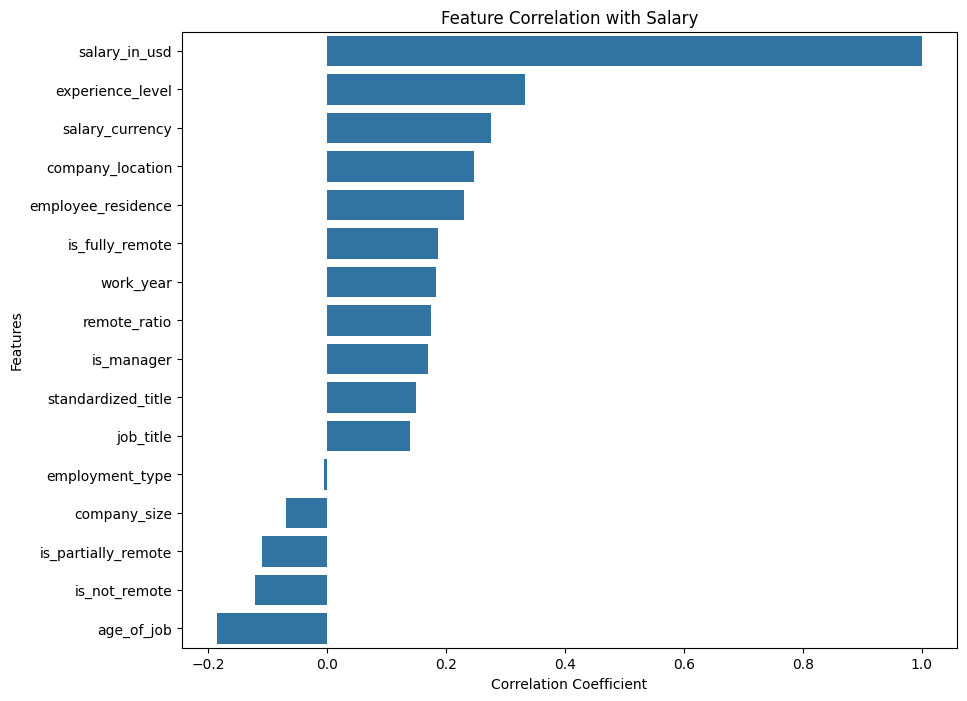

In [9]:
correlation_matrix = salaries.corr()
salary_corr = correlation_matrix['salary_in_usd']
sorted_salary_corr = salary_corr.sort_values(ascending=False)

# Create the plot
plt.figure(figsize=(10, 8))
ax = sns.barplot(x=sorted_salary_corr.values, y=sorted_salary_corr.index)


plt.title('Feature Correlation with Salary')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Features')
plt.show()

### Refining Feature Set and Reassessing Correlation
After the initial correlation analysis, this code refines the feature set by removing less relevant features, potentially to improve model performance. The steps are:
- Dropping specified columns that may not significantly impact the salary prediction.
- Recalculating the correlation matrix without these features.
- Plotting the updated correlation coefficients to reassess the feature importance with respect to `salary_in_usd`.


In [10]:
columns_to_drop =  ['employment_type', 'company_size', 'job_title']

salaries = salaries.drop(columns=columns_to_drop)

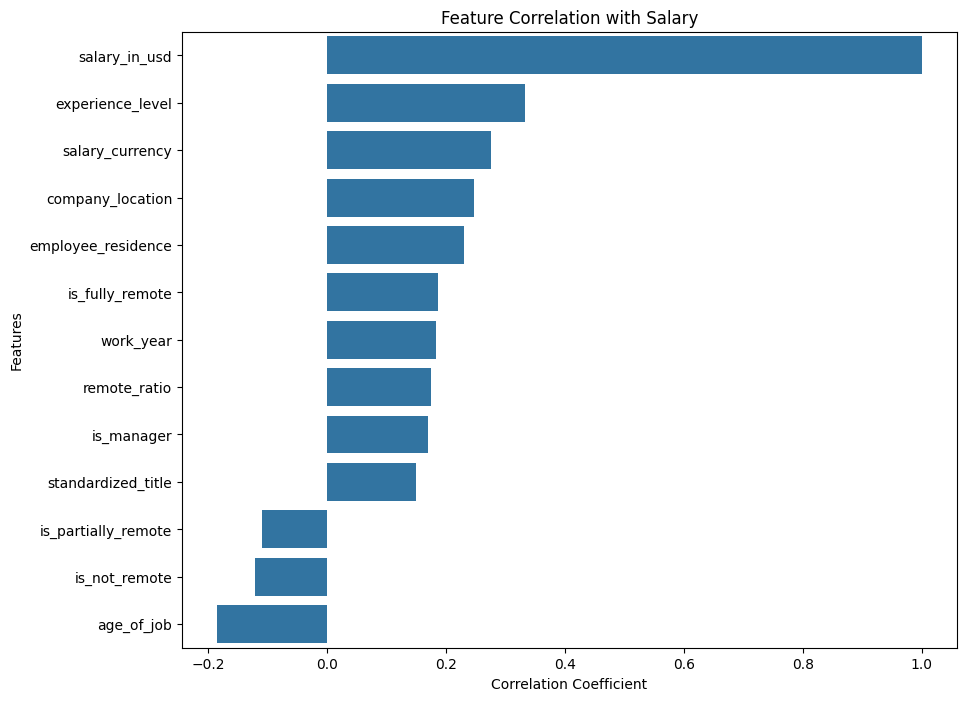

In [11]:
correlation_matrix = salaries.corr()
salary_corr = correlation_matrix['salary_in_usd']
sorted_salary_corr = salary_corr.sort_values(ascending=False)

# Create the plot
plt.figure(figsize=(10, 8))
ax = sns.barplot(x=sorted_salary_corr.values, y=sorted_salary_corr.index)


plt.title('Feature Correlation with Salary')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Features')
plt.show()

### Outlier Detection in Salary Data
The first code chunk creates a boxplot to visualize the distribution of salaries and identify potential outliers. It helps in understanding the spread of the salary data and highlights extreme values that could affect the analysis.

### Cleaning the Data by Removing Outliers
Following outlier detection, the second chunk removes salaries above $250,000, which are considered outliers for this dataset. A second boxplot is then created to confirm the removal of these outliers and to ensure the salary distribution is now more representative of the typical data range.


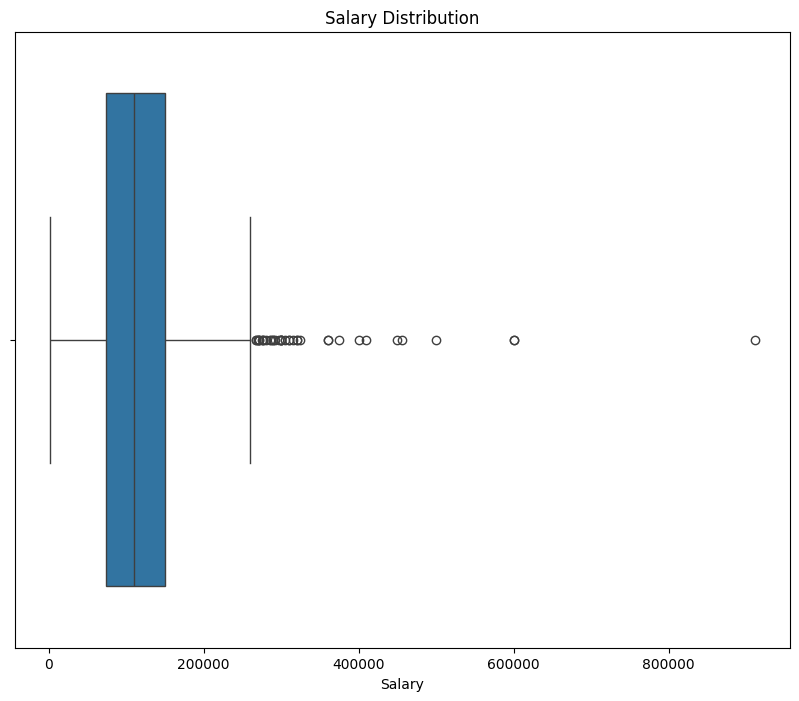

In [12]:
# Plot the salaries to identify outliers
plt.figure(figsize=(10, 8))
ax = sns.boxplot(x=salaries['salary_in_usd'])
plt.title('Salary Distribution')
plt.xlabel('Salary')
plt.show()

In [13]:
# Remove salaries above 250,000
salaries = salaries[salaries['salary_in_usd'] < 250000]

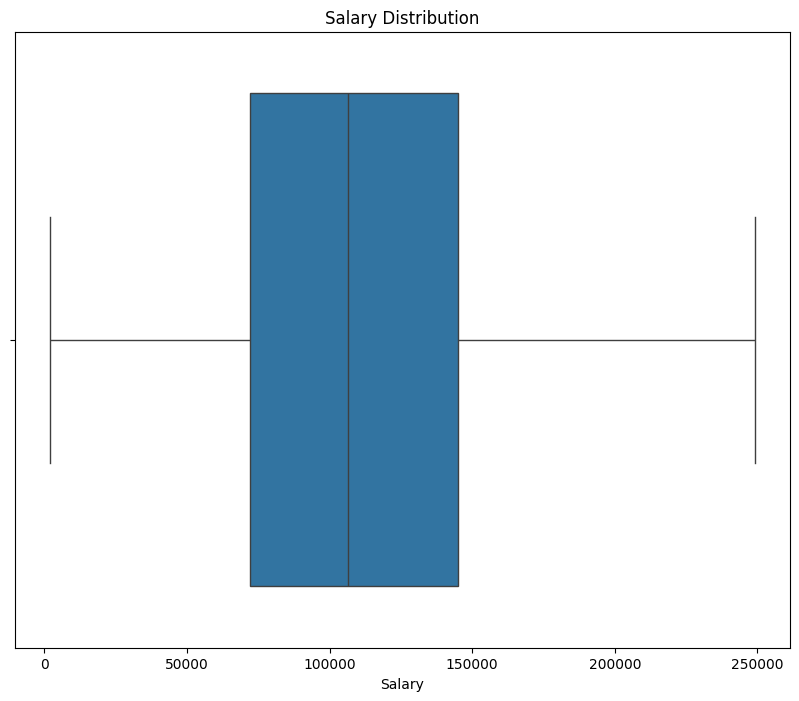

In [14]:
# Plot the salaries to identify outliers
plt.figure(figsize=(10, 8))
ax = sns.boxplot(x=salaries['salary_in_usd'])
plt.title('Salary Distribution')
plt.xlabel('Salary')
plt.show()

### Data Preparation for Model Training
Before training machine learning models, the dataset must be preprocessed. This step is going to:
- Separates features (`X`) from the target variable (`salary_in_usd`, `y`).
- Scales the features and the target to standardize their ranges using `StandardScaler`.




In [15]:
# Prepare data for training
X = salaries.drop('salary_in_usd', axis=1)  # Features
y = salaries['salary_in_usd']  # Target

In [16]:
scaler = StandardScaler()
print(X.columns)
X = pd.DataFrame(scaler.fit_transform(X))

y_scaler = StandardScaler()
y = pd.DataFrame(y_scaler.fit_transform(pd.DataFrame(y)))

Index(['work_year', 'experience_level', 'salary_currency',
       'employee_residence', 'remote_ratio', 'company_location',
       'standardized_title', 'age_of_job', 'is_manager', 'is_fully_remote',
       'is_partially_remote', 'is_not_remote'],
      dtype='object')


### Model Training and Evaluation with K-Fold Cross-Validation
This section implements K-Fold Cross-Validation to train and evaluate Gradient Boosting and Random Forest models. The steps include:
- Setting up K-Fold Cross-Validation with 100 splits for robust validation.
- Initializing model dictionaries to store instances and performance metrics.
- Iteratively training models on each fold and evaluating Mean Squared Error (MSE) and R2 Score.
- Storing models and scores only if the R2 Score is positive, indicating performance better than a naive mean predictor.


In [17]:
# K-Fold validation setup
kf = KFold(n_splits=100, shuffle=True, random_state=42)
# Initialize dictionaries to save models and scores
models = {'GradientBoosting': [], 'RandomForest': []}
mse_scores = {'GradientBoosting': [], 'RandomForest': []}
r2_scores = {'GradientBoosting': [], 'RandomForest': []}


In [18]:
fold = 0
y = y.iloc[:, 0]
for train_index, val_index in kf.split(X):
    fold += 1
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

     # Initialize and train models
    model_types = {
        'GradientBoosting': GradientBoostingRegressor(n_estimators=105, learning_rate=0.1, max_depth=3, random_state=42),
        'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42)
    }

    for model_name, model_instance in model_types.items():
        model_instance.fit(X_train, y_train)
        y_pred = model_instance.predict(X_val)
        mse = mean_squared_error(y_val, y_pred)
        r2 = r2_score(y_val, y_pred)
        
        print(f"{model_name} - Fold {fold} - MSE: {mse}, R2 Score: {r2}")
        
        # Only append to models if R2 score > 0
        if r2 > 0:
            models[model_name].append(model_instance)

            mse_scores[model_name].append(mse)
            r2_scores[model_name].append(r2)
        
        print(f"{model_name} - Fold {fold} - MSE: {mse}, R2 Score: {r2}")

GradientBoosting - Fold 1 - MSE: 0.44908192806730746, R2 Score: 0.25015608114113397
GradientBoosting - Fold 1 - MSE: 0.44908192806730746, R2 Score: 0.25015608114113397
RandomForest - Fold 1 - MSE: 0.39315435240386476, R2 Score: 0.34353982670451844
RandomForest - Fold 1 - MSE: 0.39315435240386476, R2 Score: 0.34353982670451844
GradientBoosting - Fold 2 - MSE: 0.3373641795796882, R2 Score: 0.6053009652087233
GradientBoosting - Fold 2 - MSE: 0.3373641795796882, R2 Score: 0.6053009652087233
RandomForest - Fold 2 - MSE: 0.25882547307363485, R2 Score: 0.6971872813265623
RandomForest - Fold 2 - MSE: 0.25882547307363485, R2 Score: 0.6971872813265623
GradientBoosting - Fold 3 - MSE: 0.48771634807334086, R2 Score: 0.5265758833440848
GradientBoosting - Fold 3 - MSE: 0.48771634807334086, R2 Score: 0.5265758833440848
RandomForest - Fold 3 - MSE: 0.6318427466211535, R2 Score: 0.38667302138581405
RandomForest - Fold 3 - MSE: 0.6318427466211535, R2 Score: 0.38667302138581405
GradientBoosting - Fold 4 

RandomForest - Fold 26 - MSE: 0.6617936097718484, R2 Score: 0.5074988102854618
RandomForest - Fold 26 - MSE: 0.6617936097718484, R2 Score: 0.5074988102854618
GradientBoosting - Fold 27 - MSE: 0.37251262880886454, R2 Score: 0.5844416149738176
GradientBoosting - Fold 27 - MSE: 0.37251262880886454, R2 Score: 0.5844416149738176
RandomForest - Fold 27 - MSE: 0.4443893922148569, R2 Score: 0.5042591207120488
RandomForest - Fold 27 - MSE: 0.4443893922148569, R2 Score: 0.5042591207120488
GradientBoosting - Fold 28 - MSE: 0.4439262347261166, R2 Score: 0.35193818810564625
GradientBoosting - Fold 28 - MSE: 0.4439262347261166, R2 Score: 0.35193818810564625
RandomForest - Fold 28 - MSE: 0.47522126016124355, R2 Score: 0.30625242029045774
RandomForest - Fold 28 - MSE: 0.47522126016124355, R2 Score: 0.30625242029045774
GradientBoosting - Fold 29 - MSE: 0.5843094444542987, R2 Score: 0.6112765161110483
GradientBoosting - Fold 29 - MSE: 0.5843094444542987, R2 Score: 0.6112765161110483
RandomForest - Fold 

GradientBoosting - Fold 52 - MSE: 1.0454463550283983, R2 Score: 0.11307001917563075
GradientBoosting - Fold 52 - MSE: 1.0454463550283983, R2 Score: 0.11307001917563075
RandomForest - Fold 52 - MSE: 0.8622586198395875, R2 Score: 0.2684818140293783
RandomForest - Fold 52 - MSE: 0.8622586198395875, R2 Score: 0.2684818140293783
GradientBoosting - Fold 53 - MSE: 0.21790707174409632, R2 Score: 0.5170685131818754
GradientBoosting - Fold 53 - MSE: 0.21790707174409632, R2 Score: 0.5170685131818754
RandomForest - Fold 53 - MSE: 0.22578405531177337, R2 Score: 0.4996113312945084
RandomForest - Fold 53 - MSE: 0.22578405531177337, R2 Score: 0.4996113312945084
GradientBoosting - Fold 54 - MSE: 0.738468397049889, R2 Score: 0.6152038044318042
GradientBoosting - Fold 54 - MSE: 0.738468397049889, R2 Score: 0.6152038044318042
RandomForest - Fold 54 - MSE: 0.7499946713176892, R2 Score: 0.6091977701789593
RandomForest - Fold 54 - MSE: 0.7499946713176892, R2 Score: 0.6091977701789593
GradientBoosting - Fold 

RandomForest - Fold 77 - MSE: 0.3549961847922389, R2 Score: 0.6776407331015035
RandomForest - Fold 77 - MSE: 0.3549961847922389, R2 Score: 0.6776407331015035
GradientBoosting - Fold 78 - MSE: 0.4262219174362701, R2 Score: 0.6282800966096862
GradientBoosting - Fold 78 - MSE: 0.4262219174362701, R2 Score: 0.6282800966096862
RandomForest - Fold 78 - MSE: 0.8002173068349947, R2 Score: 0.30210839044325344
RandomForest - Fold 78 - MSE: 0.8002173068349947, R2 Score: 0.30210839044325344
GradientBoosting - Fold 79 - MSE: 0.25612936050327534, R2 Score: 0.09164504766520254
GradientBoosting - Fold 79 - MSE: 0.25612936050327534, R2 Score: 0.09164504766520254
RandomForest - Fold 79 - MSE: 0.067099017913392, R2 Score: 0.7620353828289377
RandomForest - Fold 79 - MSE: 0.067099017913392, R2 Score: 0.7620353828289377
GradientBoosting - Fold 80 - MSE: 0.2833343659256678, R2 Score: 0.6421159286379596
GradientBoosting - Fold 80 - MSE: 0.2833343659256678, R2 Score: 0.6421159286379596
RandomForest - Fold 80 -

### Reporting Final Model Performance Metrics
After model training and evaluation, this code aggregates the final performance metrics. It computes and prints the average Mean Squared Error (MSE) and R2 Score for both Gradient Boosting and Random Forest models. It also reports the number of saved models after cross-validation, giving an indication of the models' generalizability and performance consistency.


In [19]:
# Report final validation metrics
for model_name in models.keys():
    print(f"{model_name} - Average MSE:", np.mean(mse_scores[model_name]), " Saved Models:", len(models[model_name]))
    print(f"{model_name} - Average R2 Score:", np.mean(r2_scores[model_name]), " Saved Models:", len(models[model_name]))

GradientBoosting - Average MSE: 0.4481490387527555  Saved Models: 95
GradientBoosting - Average R2 Score: 0.5214085838634542  Saved Models: 95
RandomForest - Average MSE: 0.46330788100217607  Saved Models: 92
RandomForest - Average R2 Score: 0.5121076849084278  Saved Models: 92


### Preparing and Transforming Test Data for Prediction
This block of code prepares new test data for predictions by:
- Encoding categorical variables using the same label encoders as the training data.
- Applying the same feature engineering steps to ensure consistency with the training data.
- Dropping columns that were not used during model training.
- Scaling the features using the same scaler fitted on the training data.



In [20]:
test_X = {
    'work_year': [2023, 2023, 2023, 2023, 2023, 2023, 2023, 2023, 2023, 2023],
    'experience_level': ['EN', 'MI', 'SE', 'EX', 'EN', 'MI', 'SE', 'EX', 'EN', 'MI'],
    'employment_type': ['PT', 'PT', 'FT', 'FT', 'CT', 'CT', 'FL', 'FL', 'FT', 'FT'],
    'job_title': [
        'Application Security Engineer', 
        'Security Analyst', 
        'Chief Information Security Officer', 
        'Ethical Hacker',
        'Security Consultant',
        'Information Security Analyst',
        'Security Analyst',
        'Penetration Tester',
        'Application Security Engineer', 
        'Information Security Analyst'
    ],
    'salary_currency': ['USD', 'USD', 'USD', 'USD', 'USD', 'USD', 'USD', 'USD', 'USD', 'USD'],
    'salary_in_usd': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    'employee_residence': ['US', 'US', 'US', 'US', 'US', 'US', 'US', 'US', 'CA', 'CA'],
    'remote_ratio': [100, 50, 100, 0, 100, 50, 100, 0, 50, 50],
    'company_location': ['US', 'US', 'CA', 'US', 'US', 'US', 'US', 'US', 'CA', 'CA'],
    'company_size': ['M', 'S', 'L', 'M', 'S', 'L', 'M', 'S', 'M', 'L']
}


test_X_df = pd.DataFrame(test_X)

test_X_df = feature_engineering(test_X_df)

# Assuming test_X_df contains your test data in DataFrame format
# Only label encode columns that were label encoded in training set
for column in encoding_columns:
    encoder = encoders[column]
    test_X_df[column] = encoder.transform(test_X_df[column])

# Drop columns that were dropped in training set
test_X_df = test_X_df.drop(columns=columns_to_drop)

test_X_df = test_X_df.drop('salary_in_usd', axis=1)  # Features

print(test_X_df.columns)

# Apply scaling
test_X_df_scaled = scaler.transform(test_X_df)


Index(['work_year', 'experience_level', 'salary_currency',
       'employee_residence', 'remote_ratio', 'company_location',
       'standardized_title', 'age_of_job', 'is_manager', 'is_fully_remote',
       'is_partially_remote', 'is_not_remote'],
      dtype='object')


### Making Predictions with an Ensemble Approach
The final step uses an ensemble method to predict salaries using the processed test data. The approach involves:
- Aggregating predictions from multiple trained models (Gradient Boosting and Random Forest) to create an ensemble prediction.
- Averaging predictions from all models of each type, then averaging across model types to produce a final prediction.
- Inversely transforming the scaled predictions back to the original salary scale.



In [23]:
def ensemble_predict(models_dict, X_new):
    # Initialize an array to store predictions from all models
    all_predictions = np.zeros((X_new.shape[0], 0))

    # Generate predictions from each type of model
    for model_type, model_list in models_dict.items():
        type_predictions = np.zeros((X_new.shape[0], len(model_list)))
        
        # Generate predictions from each individual model of this type
        for i, model in enumerate(model_list):
            type_predictions[:, i] = model.predict(X_new)

        # Average predictions from all models of this type
        avg_type_prediction = np.mean(type_predictions, axis=1).reshape(-1, 1)
        
        # Concatenate these average predictions to all_predictions
        all_predictions = np.hstack([all_predictions, avg_type_prediction])

    # Average over axis 1 (the different model types) to get the final prediction
    avg_prediction = np.mean(all_predictions, axis=1)

    return avg_prediction

In [24]:
y_pred = ensemble_predict(models, test_X_df_scaled)
print(y_pred)
# Inverse transform the predictions
y_pred = y_scaler.inverse_transform(y_pred.reshape(-1, 1))
print(y_pred)

[-0.57401021  0.23963161  0.55427145  0.85618562 -0.58038436  0.23963161
  0.58363425  1.42500462 -0.5955846   0.05941132]
[[ 81598.37957362]
 [123661.01838149]
 [139926.87594203]
 [155534.85752542]
 [ 81268.85675472]
 [123661.01838149]
 [141444.83740546]
 [184940.95240668]
 [ 80483.05336211]
 [114344.21500101]]


## Explaination

[-0.57401021, 0.23963161, 0.55427145, 0.85618562, -0.58038436, 0.23963161, 0.58363425, 1.42500462, -0.5955846, 0.05941132]

These are the predictions made by the ensemble model, which have been standardized (scaled) to have a mean of 0 and a standard deviation of 1. This is the same scaling that was applied to the training data before fitting the model. The scaled predictions cannot be interpreted directly in terms of salary values because they don't represent the actual dollar amounts. Instead, they represent how many standard deviations away from the mean salary the predictions are. For example, a score of -0.574 means the predicted salary is 0.574 standard deviations below the mean salary of the training dataset.

[[ 81598.37957362],
 [123661.01838149],
 [139926.87594203],
 [155534.85752542],
 [ 81268.85675472],
 [123661.01838149],
 [141444.83740546],
 [184940.95240668],
 [ 80483.05336211],
 [114344.21500101]]
 
These are the actual salary predictions for the test data, converted back to dollar values from the scaled predictions. This inverse transformation is done using the y_scaler, which was fitted on the salary data of the training set. It reverses the scaling process to transform the data back to its original distribution and scale.

Now, each value represents a predicted annual salary in USD for the corresponding test data point. For example, the first prediction is approximately 81,598 USD, while the eighth prediction is approximately 184,941 USD.

### Project Conclusion and Summary
This project encompassed a comprehensive workflow for predicting cybersecurity salaries using machine learning. Key phases included:

1. **Data Preparation**: Loading the dataset, performing exploratory data analysis, and conducting feature engineering to extract meaningful variables.

2. **Preprocessing**: Handling missing values, encoding categorical variables, and scaling features to prepare the data for modeling.

3. **Model Building**: Implementing Gradient Boosting and Random Forest models, and evaluating their performance using K-Fold cross-validation.

4. **Ensemble Prediction**: Combining multiple models to predict salaries on new data, leveraging the collective power of the ensemble for improved accuracy.

5. **Results Interpretation**: Inversely transforming the predictions to obtain the final salary estimates in USD.

The project outcomes suggest that the ensemble model is capable of providing reasonable salary predictions based on various job-related features. The successful application of feature engineering, cross-validation, and ensemble methods demonstrates a robust approach to predictive modeling in the domain of salary prediction.

Going forward, these results can be used to inform compensation strategies, career decisions, and to gain insights into the cybersecurity job market. Further model tuning, feature selection, and the incorporation of additional data could enhance the model's predictive power.
